In [63]:
#libraries
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import math as math
from scipy.optimize import root_scalar
from scipy.optimize import fsolve
from matplotlib.ticker import ScalarFormatter

In [64]:
# Set global theme settings for plotting
plt.rcParams.update({
    'font.size': 20,          # Set font size
    'lines.linewidth': 3,     # Set default line thickness
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # Axis label font size
    'xtick.labelsize': 14,    # X-tick label font size
    'ytick.labelsize': 14,    # Y-tick label font size
    'grid.color': 'gray',     # Grid color
    'grid.linestyle': '--',   # Grid line style
    'grid.linewidth': 0.5,    # Grid line width
    'legend.fontsize': 16     # Legend font size
})

In [65]:
#Arguments used to calculate Ne
#20000 human genes, each human gene is a linkage block
totallinkageblocks = 20000
chromosomenumber=23

humanUd = [2.0, 10.0]
Kimetalsd=0.009
Boykoetalsd=0.029

log10humanUd = np.log10(humanUd)
Udcolor = '#009E73'
log10Kim = np.log10(Kimetalsd)
Kimcolor = '#E69F00'
log10Boyko = np.log10(Boykoetalsd)
Boykocolor = '#56B4E9'

N1=200
N1color = '#F0E442'
N2=2000
N2color = '#CC79A7'
N3=20000
N3color = '#D55E00'

deterministiccolor = 'black'


In [66]:
#function returns Ne as in Matheson and Masel 2024. 
#r=2 per chromosome, two recombination events for chromosome arm
def calculate_Ne(Ud, sh, totallinkageblocks, chromosomenumber, N):
  Ne = N*np.exp(-8*Ud*(1-(1/totallinkageblocks))*sh)*np.exp(-Ud/(chromosomenumber*2))
  return Ne

#working on this, check that the signs of the math work first
def PfixDFE(x, Ud, sd, totallinkageblocks, chromosomenumber, N):
  Ne = calculate_Ne(Ud, sd, totallinkageblocks, chromosomenumber, N)
  Pfix = (1-np.exp(-x, dtype=np.float128))/(1-np.exp(-4*Ne*(-x), dtype=np.float128))
  DFE = np.exp(-x/(sd), dtype=np.float128)/sd
  return Pfix*DFE

def calculate_PfixDFE(Ud, sd, totallinkageblocks, chromosomenumber, N):
  result = integrate.quad(PfixDFE, 0, 1, args=(Ud, sd, totallinkageblocks, chromosomenumber, N))
  return abs(result[0])

#Next function has to be zero to find the point where deterministic and stochastic accumulation equals each other
def calculate_stochastic_accumulation(Ud, sd, totallinkageblocks, chromosomenumber, N):
  stochastic_accumulation = Ud*N*calculate_PfixDFE(Ud, sd, totallinkageblocks, chromosomenumber, N)
  return stochastic_accumulation


#working on this, check that the signs of the math work first
def NPfix(Ud, sd, totallinkageblocks, chromosomenumber, N):
  Ne = calculate_Ne(Ud, sd, totallinkageblocks, chromosomenumber, N)
  Pfix = (1-np.exp(-2*(-sd)))/(1-np.exp(-4*Ne*(-sd)))
  return N*Pfix

def calculate_NPfix(Ud, sd, totallinkageblocks, chromosomenumber, N):
  result = NPfix(Ud, sd, totallinkageblocks, chromosomenumber, N)
  return result

#Calculate deterministic mutation accumulation
def calculate_deterministic_accumulation(Ud, sh):
  deterministic_accumulation = Ud*(1-(1/(4.9*np.sqrt(Ud*sh))))
  return deterministic_accumulation

#Next function has to be zero to find the point where deterministic and stochastic accumulation equals each other
def calculate_deterministic_contribution(Ud, sh):
  deterministic_contribution = 1-(1/(4.9*np.sqrt(Ud*sh)))
  return deterministic_contribution


#Next function has to be zero to find the point where deterministic and stochastic accumulation equals each other
def calculate_difference_equation(Ud, sd, totallinkageblocks, chromosomenumber, N):
  deterministic_accumulation = calculate_deterministic_accumulation(Ud, sd)
  stochastic_accumulation = calculate_stochastic_accumulation(Ud, sd, totallinkageblocks, chromosomenumber, N)
  difference = deterministic_accumulation-stochastic_accumulation
  return difference

def calculate_ratio_equation(Ud, sd, totallinkageblocks, chromosomenumber, N):
  deterministic_accumulation = calculate_deterministic_accumulation(Ud, sd)
  stochastic_accumulation = calculate_stochastic_accumulation(Ud, sd, totallinkageblocks, chromosomenumber, N)
  ratio = deterministic_accumulation/stochastic_accumulation
  return ratio

def find_Udroot_difference(sd, totallinkageblocks, chromosomenumber, N, x0):
  result = fsolve(lambda Ud: calculate_difference_equation(Ud, sd, totallinkageblocks, chromosomenumber, N), x0)
  return result

def find_Udroot_deterministic(sd, x0):
  result = fsolve(lambda Ud: calculate_deterministic_contribution(Ud, sd), x0)
  return result

Text(0.5, 0, 'log10(sd)')

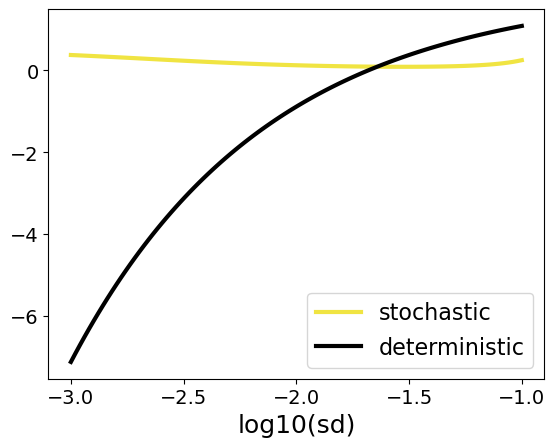

In [67]:
#testing the calculate_stochastic_accumulation using different sd 

sd = 10**(np.linspace(start=-3, stop=-1, num=100))
Ud_test = 2
vStochastic_acc = np.vectorize(calculate_stochastic_accumulation)
stochastic_acc = vStochastic_acc(Ud_test, sd, totallinkageblocks, chromosomenumber, N1)
deterministic_acc = calculate_deterministic_accumulation(Ud_test, sd)
log10sd = np.log10(sd)

plt.plot(log10sd, stochastic_acc, label = 'stochastic', color = N1color)
plt.plot(log10sd, deterministic_acc, label = 'deterministic', color = deterministiccolor)
plt.legend()
plt.xlabel('log10(sd)')


Text(0, 0.5, 'deterministic minus stochastic contribution')

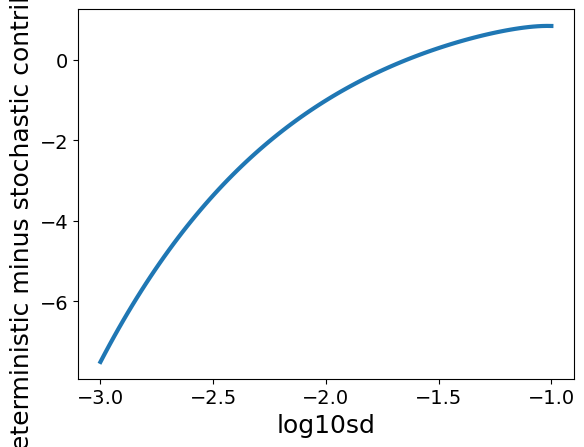

In [68]:
#testing the calculate_difference_equation 
#This function can be use with a rooting algorithm to calculate where the deterministic equation predicts a higher accumulation rate than the stpochastic equation
sd = 10**(np.linspace(start=-3, stop=-1, num=100))
Ud_test = 2
vDifference = np.vectorize(calculate_difference_equation)
diff_stoch_det = vDifference(Ud_test, sd, totallinkageblocks, chromosomenumber, N1)
log10sd = np.log10(sd)

plt.plot(log10sd, diff_stoch_det)
plt.xlabel('log10sd')
plt.ylabel('deterministic minus stochastic contribution')

/tmp/ipykernel_61792/869537773.py:10: RuntimeWarning: overflow encountered in exp
  Pfix = (1-np.exp(-x, dtype=np.float128))/(1-np.exp(-4*Ne*(-x), dtype=np.float128))


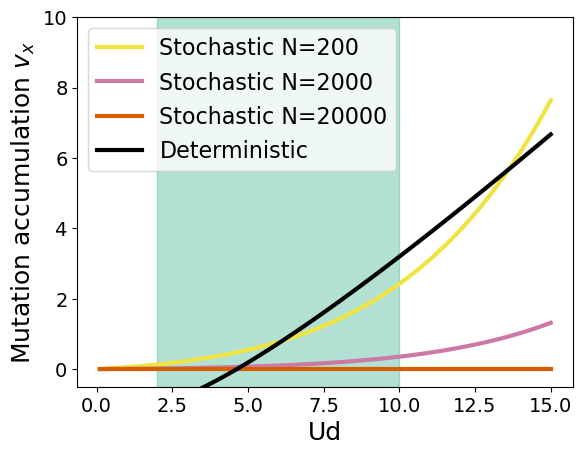

In [69]:
#accumulation contribution for Kim et al 
Ud = np.linspace(start=0.1, stop=15, num=100)
deterministic_acc = calculate_deterministic_accumulation(Ud, Kimetalsd)
vStochastic_acc = np.vectorize(calculate_stochastic_accumulation)

stochastic_acc_N1 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N1)
stochastic_acc_N2 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N2)
stochastic_acc_N3 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N3)

stochastic_label = 'Stochastic N='
deterministic_label = 'Deterministic'
Kimplot = plt.figure()
plt.plot(Ud, stochastic_acc_N1, label = f"{stochastic_label}{N1}", color = N1color)
plt.plot(Ud, stochastic_acc_N2, label = f"{stochastic_label}{N2}", color = N2color)
plt.plot(Ud, stochastic_acc_N3, label = f"{stochastic_label}{N3}", color = N3color)
plt.plot(Ud, deterministic_acc, label = deterministic_label, color = deterministiccolor)
plt.legend()
plt.xlabel('Ud')
plt.ylabel(r"Mutation accumulation $v_{x}$")
plt.ylim(-0.5, 10) 
plt.axvspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.3)
plt.savefig('../graphs/Kimsd_mutationaccumulation.png', dpi=300)


/tmp/ipykernel_61792/869537773.py:10: RuntimeWarning: overflow encountered in exp
  Pfix = (1-np.exp(-x, dtype=np.float128))/(1-np.exp(-4*Ne*(-x), dtype=np.float128))


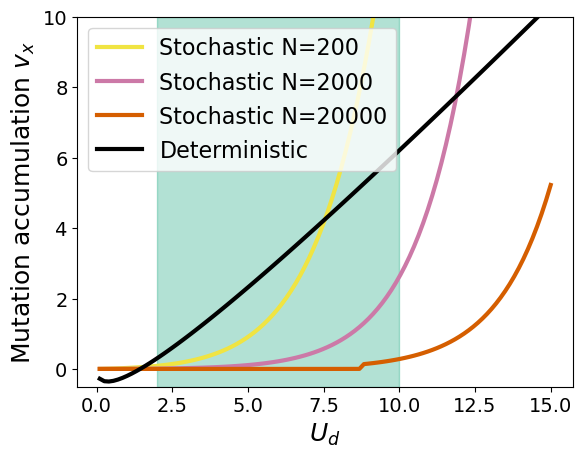

In [70]:
#accumulation contribution for Boyko et al 

Ud = np.linspace(start=0.1, stop=15, num=100)
deterministic_acc = calculate_deterministic_accumulation(Ud, Boykoetalsd)
vStochastic_acc = np.vectorize(calculate_stochastic_accumulation)

stochastic_acc_N1 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N1)
stochastic_acc_N2 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N2)
stochastic_acc_N3 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N3)

stochastic_label = 'Stochastic N='
deterministic_label = 'Deterministic'
Boykoplot = plt.figure()
plt.plot(Ud, stochastic_acc_N1, label = f"{stochastic_label}{N1}", color = N1color)
plt.plot(Ud, stochastic_acc_N2, label = f"{stochastic_label}{N2}", color = N2color)
plt.plot(Ud, stochastic_acc_N3, label = f"{stochastic_label}{N3}", color = N3color)
plt.plot(Ud, deterministic_acc, label = deterministic_label, color = deterministiccolor)
plt.legend()
plt.xlabel(r"$U_{d}$")
plt.ylabel(r"Mutation accumulation $v_{x}$")
plt.ylim(-0.5, 10) 
plt.axvspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.3)

In [71]:
#Testing how to obtain all the roots of the calculate_difference_equation
#I use fsolve from scipy.optimize to iteratively solve the equation 
initial_Udguesses = np.linspace(2, 10, 10)
vUdroot_diff = np.vectorize(find_Udroot_difference)
roots = vUdroot_diff(Boykoetalsd, totallinkageblocks, chromosomenumber, N1, initial_Udguesses)
roots = np.unique(np.round(roots, decimals=8))
print(roots[0])
print(roots[1])

1.54360742
4.66666667


/tmp/ipykernel_61792/869537773.py:36: RuntimeWarning: invalid value encountered in sqrt
  deterministic_accumulation = Ud*(1-(1/(4.9*np.sqrt(Ud*sh))))
/tmp/ipykernel_61792/869537773.py:15: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(PfixDFE, 0, 1, args=(Ud, sd, totallinkageblocks, chromosomenumber, N))
/tmp/ipykernel_61792/869537773.py:59: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  result = fsolve(lambda Ud: calculate_difference_equation(Ud, sd, totallinkageblocks, chromosomenumber, N), x0)


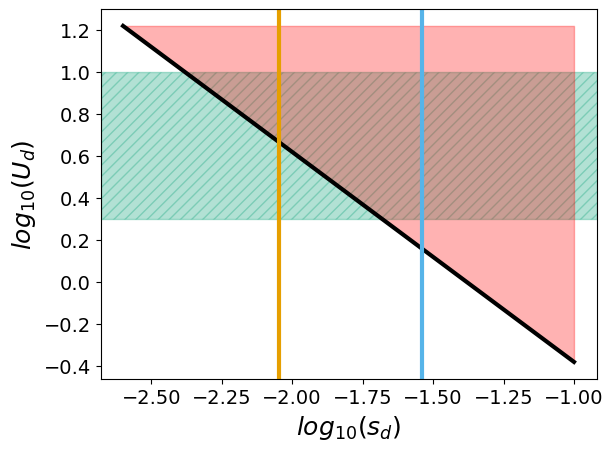

In [72]:
#Roots for the deterministic accumulation equation

sd = 10**(np.linspace(start=-2.6, stop=-1, num=100))
vUdroot_det = np.vectorize(find_Udroot_deterministic)
Udroot1 = vUdroot_det(sd, 0.2)
log10sd = np.log10(sd)
log10Udroot1 = np.log10(Udroot1)

plt.plot(log10sd, log10Udroot1, color = deterministiccolor)
plt.axvline(x = log10Kim, color = Kimcolor, label = 'Kimetal')
plt.axvline(x = log10Boyko, color = Boykocolor, label = 'Boyko')
plt.xlabel(r"$log_{10} (s_{d})$")
plt.ylabel(r"$log_{10} (U_{d})$")
plt.axhspan(log10humanUd[0], log10humanUd[1], color=Udcolor, alpha=0.3, hatch="///")
plt.fill_between(log10sd, y1=log10Udroot1, y2=max(log10Udroot1), color="red", alpha=0.3)

Text(0, 0.5, '$U_{d}$')

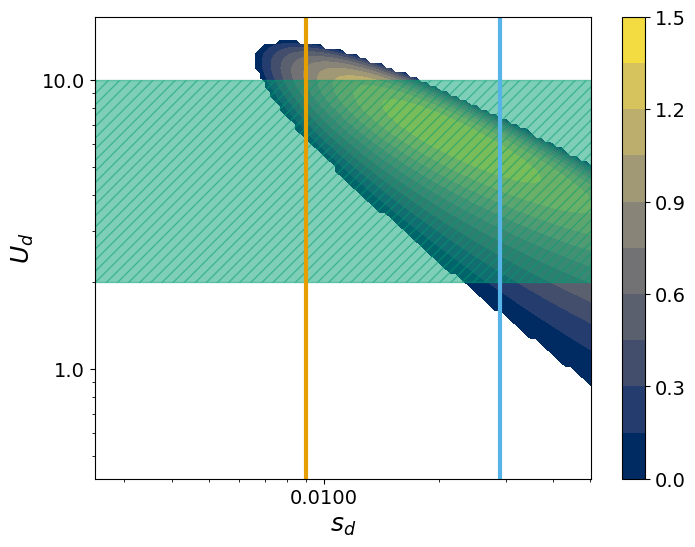

In [73]:
sd_vector = np.logspace(-2.6, -1.3, 100)
minlog10Udroot = np.log10(min(Udroot1))
maxlog10Udroot = np.log10(max(Udroot1))
Ud_vector = np.logspace(minlog10Udroot, maxlog10Udroot, 100)
sd, Ud = np.meshgrid(sd_vector, Ud_vector)

vDifference = np.vectorize(calculate_difference_equation)
diff_stoch_det_N1 = vDifference(Ud, sd, totallinkageblocks, chromosomenumber, N1)
diff_stoch_det_N1 = np.ma.masked_less(diff_stoch_det_N1, 0)
# Contour plot for small population size N1
plt.figure(figsize=(8, 6))
contourf = plt.contourf(sd, Ud, diff_stoch_det_N1, levels=10, cmap='cividis')  # filled contours
plt.colorbar(contourf)  # Add a color bar to show the scale
plt.axvline(x = Kimetalsd, color = Kimcolor, label = 'Kim')
plt.axvline(x = Boykoetalsd, color = Boykocolor, label = 'Boyko')
plt.axhspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.5, hatch="///")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel(r"$s_{d}$")
plt.ylabel(r"$U_{d}$")

Text(0, 0.5, '$U_{d}$')

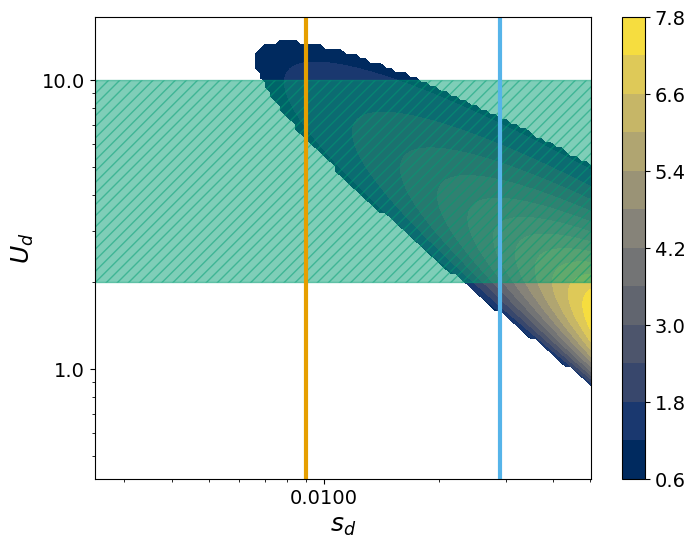

In [74]:
vRatio = np.vectorize(calculate_ratio_equation)
ratio_stoch_det_N1 = vRatio(Ud, sd, totallinkageblocks, chromosomenumber, N1)
ratio_stoch_det_N1 = np.ma.masked_less(ratio_stoch_det_N1, 1.0)
# Contour plot for small population size N1
plt.figure(figsize=(8, 6))
contourf = plt.contourf(sd, Ud, ratio_stoch_det_N1, levels=10, cmap='cividis')  # filled contours
plt.colorbar(contourf)  # Add a color bar to show the scale
plt.axvline(x = Kimetalsd, color = Kimcolor, label = 'Kim')
plt.axvline(x = Boykoetalsd, color = Boykocolor, label = 'Boyko')
plt.axhspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.5, hatch="///")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel(r"$s_{d}$")
plt.ylabel(r"$U_{d}$")

Text(0, 0.5, '$U_{d}$')

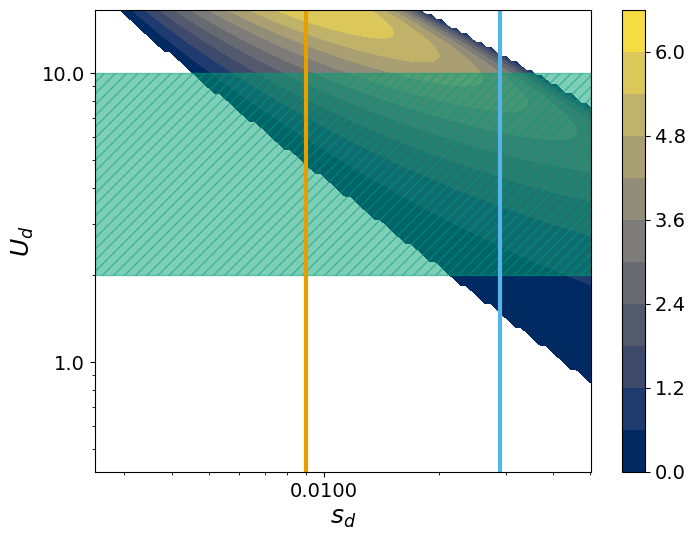

In [75]:
diff_stoch_det_N2 = vDifference(Ud, sd, totallinkageblocks, chromosomenumber, N2)
diff_stoch_det_N2 = np.ma.masked_less(diff_stoch_det_N2, 0)
# Contour plot for medium population size N2
plt.figure(figsize=(8, 6))
contourf = plt.contourf(sd, Ud, diff_stoch_det_N2, levels=10, cmap='cividis')  # filled contours
plt.colorbar(contourf)  # Add a color bar to show the scale
plt.axvline(x = Kimetalsd, color = Kimcolor, label = 'Kim')
plt.axvline(x = Boykoetalsd, color = Boykocolor, label = 'Boyko')
plt.axhspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.5, hatch="///")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel(r"$s_{d}$")
plt.ylabel(r"$U_{d}$")

Text(0, 0.5, '$U_{d}$')

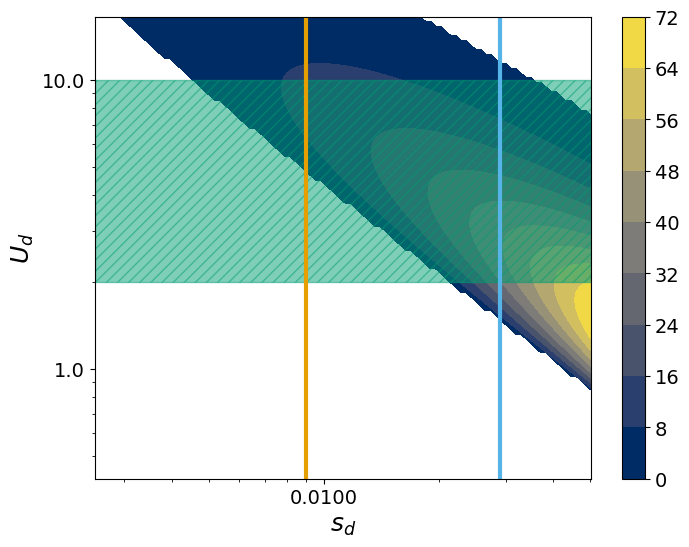

In [76]:
ratio_stoch_det_N2 = vRatio(Ud, sd, totallinkageblocks, chromosomenumber, N2)
ratio_stoch_det_N2 = np.ma.masked_less(ratio_stoch_det_N2, 1.0)
# Contour plot for small population size N1
plt.figure(figsize=(8, 6))
contourf = plt.contourf(sd, Ud, ratio_stoch_det_N2, levels=10, cmap='cividis')  # filled contours
plt.colorbar(contourf)  # Add a color bar to show the scale
plt.axvline(x = Kimetalsd, color = Kimcolor, label = 'Kim')
plt.axvline(x = Boykoetalsd, color = Boykocolor, label = 'Boyko')
plt.axhspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.5, hatch="///")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel(r"$s_{d}$")
plt.ylabel(r"$U_{d}$")

/tmp/ipykernel_61792/869537773.py:10: RuntimeWarning: overflow encountered in exp
  Pfix = (1-np.exp(-x, dtype=np.float128))/(1-np.exp(-4*Ne*(-x), dtype=np.float128))


Text(0, 0.5, '$U_{d}$')

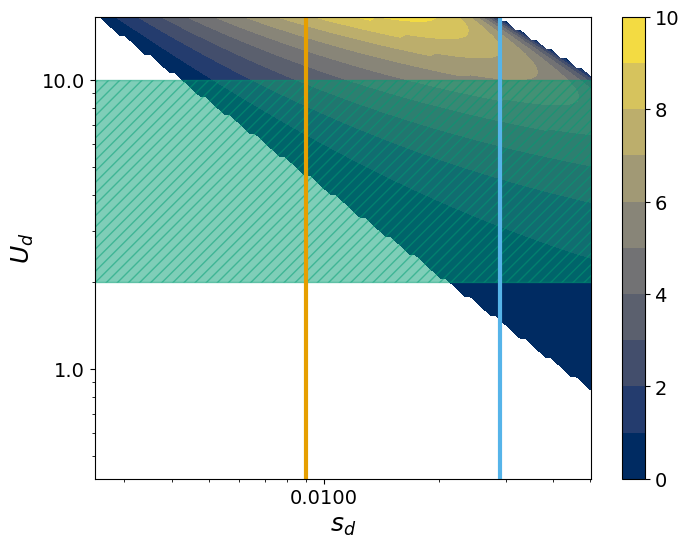

In [79]:
diff_stoch_det_N3 = vDifference(Ud, sd, totallinkageblocks, chromosomenumber, N3)
diff_stoch_det_N3 = np.ma.masked_less(diff_stoch_det_N3, 0)
# Contour plot for medium population size N3
plt.figure(figsize=(8, 6))
contourf = plt.contourf(sd, Ud, diff_stoch_det_N3, levels=10, cmap='cividis')  # filled contours
plt.colorbar(contourf)  # Add a color bar to show the scale
plt.axvline(x = Kimetalsd, color = Kimcolor, label = 'Kim')
plt.axvline(x = Boykoetalsd, color = Boykocolor, label = 'Boyko')
plt.axhspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.5, hatch="///")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel(r"$s_{d}$")
plt.ylabel(r"$U_{d}$")

/tmp/ipykernel_61792/869537773.py:10: RuntimeWarning: overflow encountered in exp
  Pfix = (1-np.exp(-x, dtype=np.float128))/(1-np.exp(-4*Ne*(-x), dtype=np.float128))


Text(0, 0.5, '$U_{d}$')

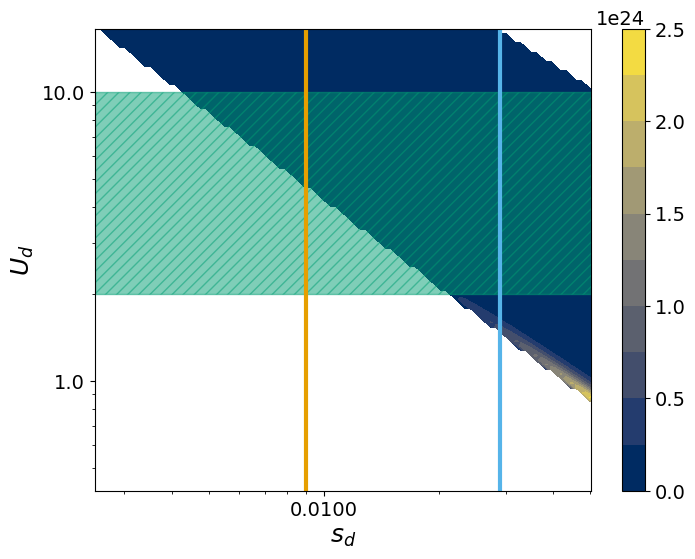

In [90]:
ratio_stoch_det_N3 = vRatio(Ud, sd, totallinkageblocks, chromosomenumber, N3)
ratio_stoch_det_N3 = np.ma.masked_less(ratio_stoch_det_N3, 1.0)
#ratio_stoch_det_N3 = np.ma.masked_greater(ratio_stoch_det_N3, 10000000000000000000000000)
# Contour plot for small population size N1
plt.figure(figsize=(8, 6))
contourf = plt.contourf(sd, Ud, ratio_stoch_det_N3, levels=10, cmap='cividis')  # filled contours
plt.colorbar(contourf)  # Add a color bar to show the scale
plt.axvline(x = Kimetalsd, color = Kimcolor, label = 'Kim')
plt.axvline(x = Boykoetalsd, color = Boykocolor, label = 'Boyko')
plt.axhspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.5, hatch="///")
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel(r"$s_{d}$")
plt.ylabel(r"$U_{d}$")